# R.A.G. Question-Answer Application Using Text Files, ChromaDB Vector Database, and HuggingFace Embedding Model

This is a bare-bones example.

## What to Look For

The main points in the code are:

1. The unindented `variables` tell you the key items required for that part of the solution.
2. The comments give additional explanation.

## Setting Up

### Settings

You need only specify two things:
1. Where your text documents are located as a relative path to this notebook.
2. The ChromaDB database location as a relative path to this notebook.

In [1]:
FILE_PATHS = [
    'rush-hour-2.txt'
]
DB_PERSISTENCE_PATH = 'chromadb'

In [2]:
# Do not touch these. They are constants that will be referenced later.
EMBEDDINGS_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
CASUAL_LANGUAGE_MODEL_NAME = 'meta-llama/Llama-3.2-3B-Instruct'
START_OF_ANSWER_MARKER = '<|start_header_id|>assistant<|end_header_id|>'
TOKEN_LIMIT = 512

### Libraries and Imports

And you need to get these installed (if not already installed) and loaded.

In [3]:
%pip install gradio langchain_chroma langchain-community langchain-huggingface openai sentence-transformers tiktoken

import re
import torch

from langchain_chroma import Chroma
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableLambda
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain_huggingface.chat_models import ChatHuggingFace
from langchain.document_loaders import TextLoader
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from os.path import isdir
from shutil import rmtree
from torch.cuda import is_available as cuda_is_available
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Detect the best device available for use.
device, torch_dtype = ('cuda', 'float16') if cuda_is_available() else ('cpu', 'float32')

# Delete the ChromaDB state first if it already exists. Otherwise, it may be loaded with duplicate documents.
if isdir(DB_PERSISTENCE_PATH):
  rmtree(DB_PERSISTENCE_PATH)

Note: you may need to restart the kernel to use updated packages.


## Loading Data

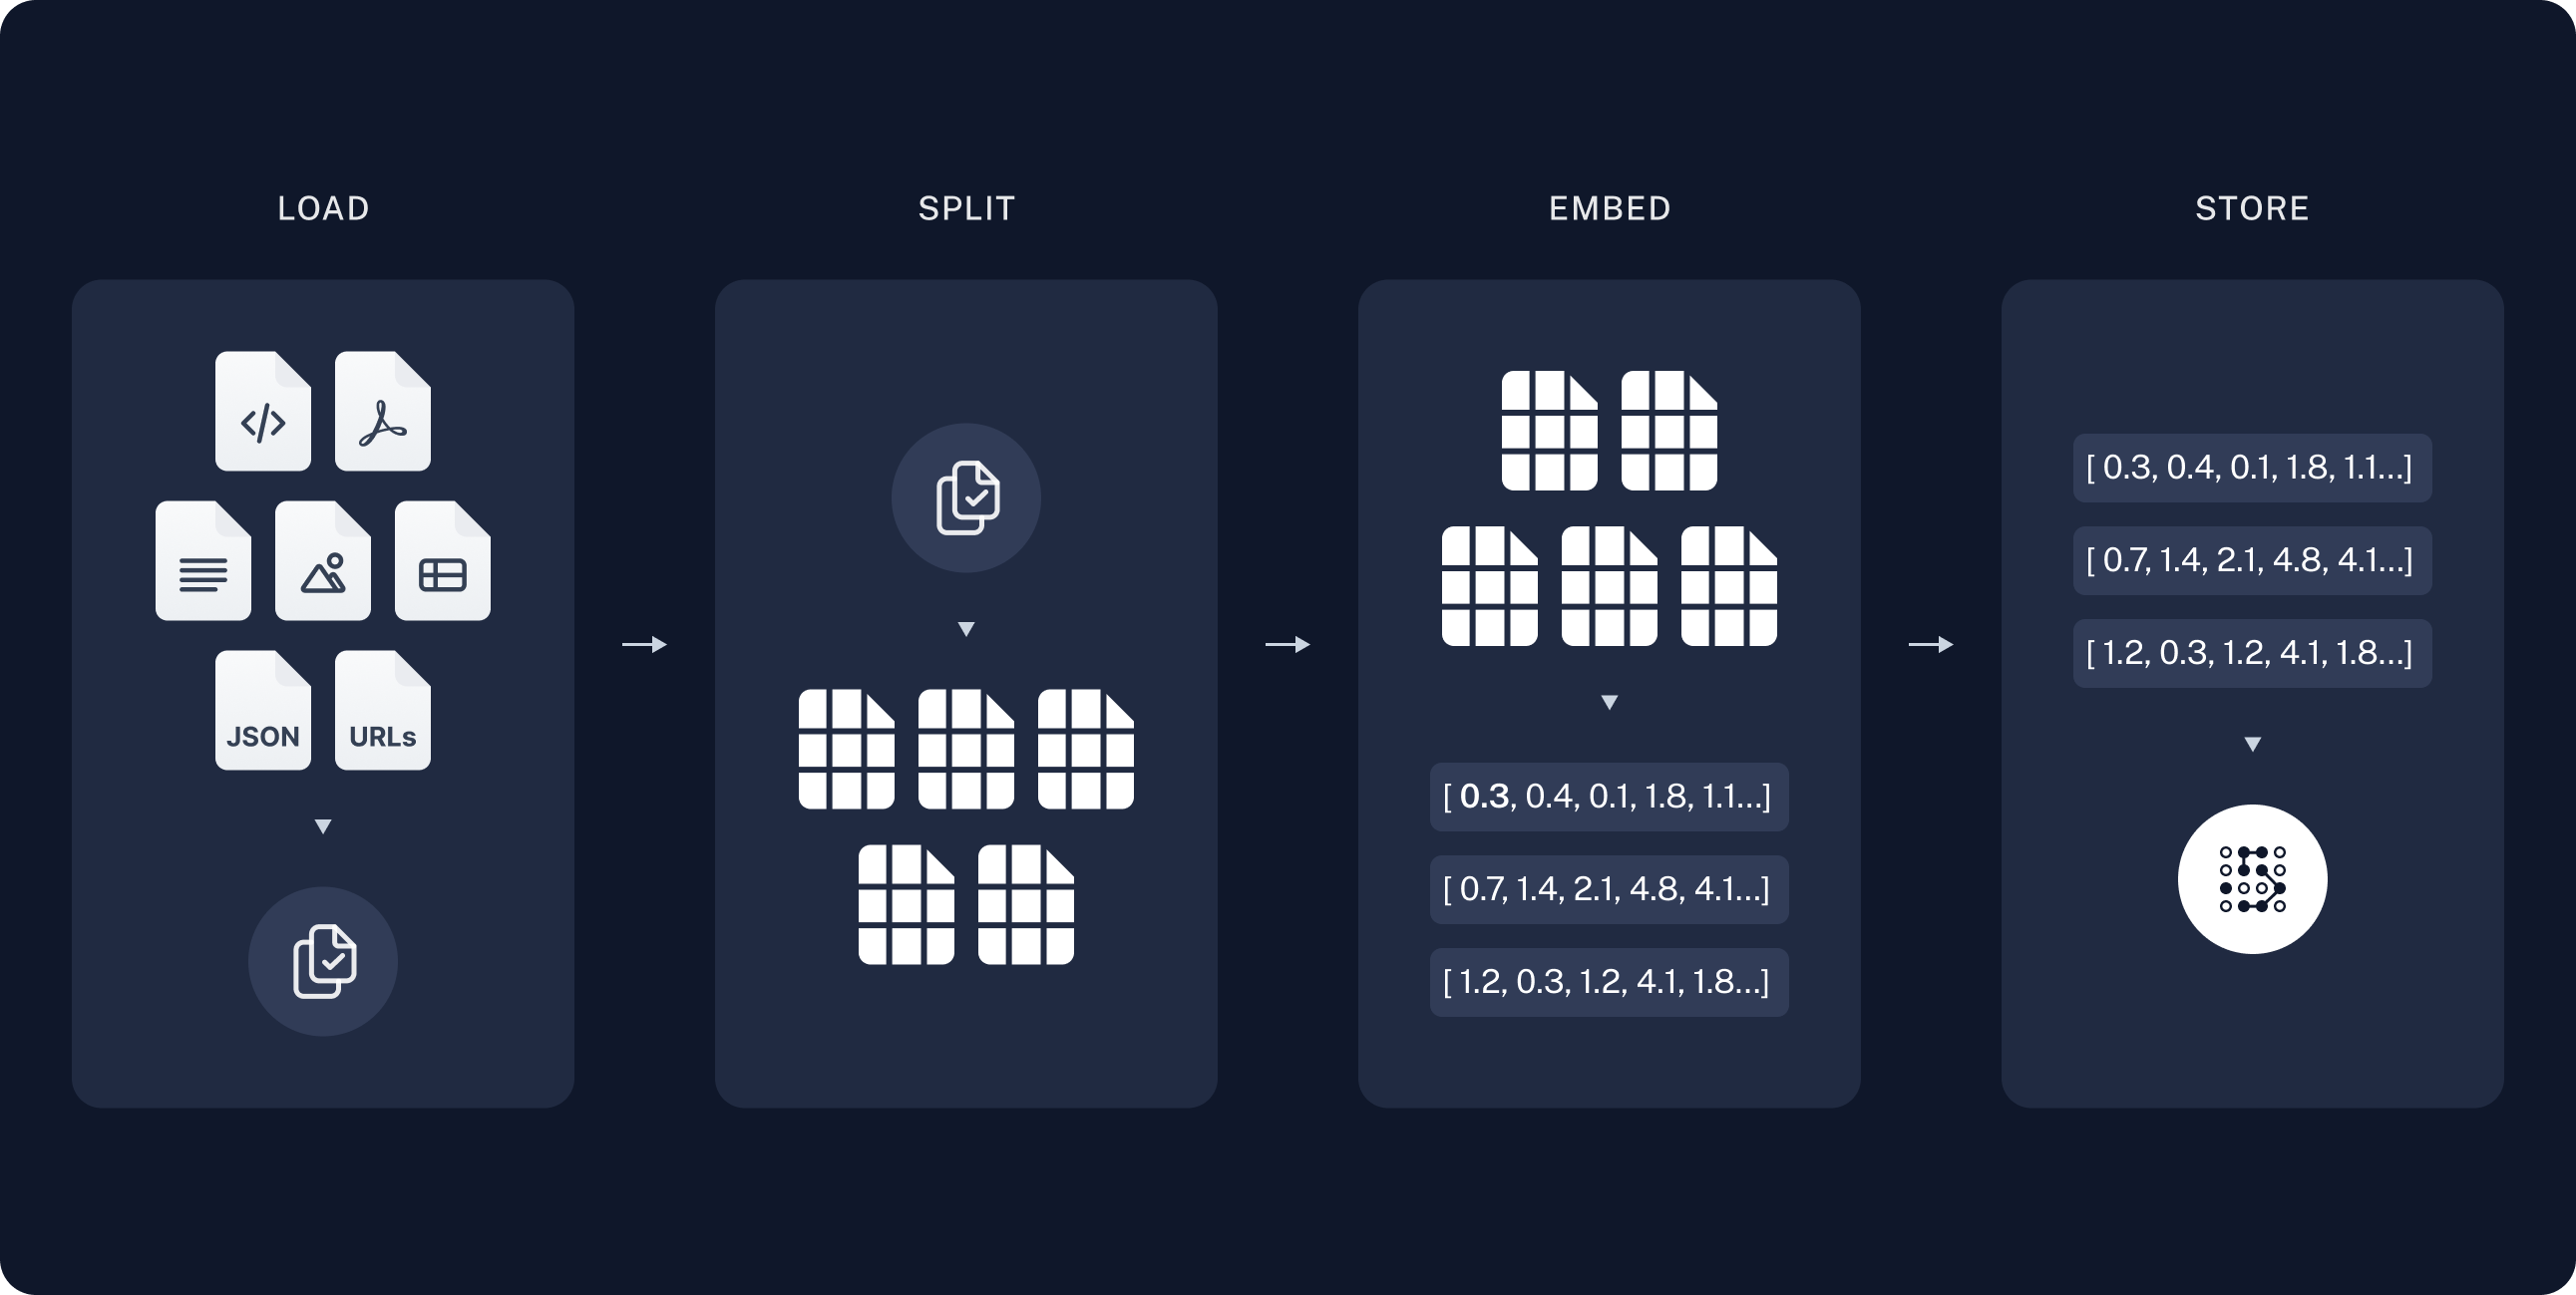

Source: [LangChain - Build a Retrieval Augmented Generation (RAG) App](https://python.langchain.com/docs/tutorials/rag/)

### Load and Split the Documents

In [4]:
documents = []

for file_path in FILE_PATHS:
  loader = TextLoader(file_path) # A loader loads one of your files.
  documents += loader.load()     # Loading loads one or more documents from a file.

print(f'Loaded {len(documents):,} documents from {len(FILE_PATHS):,} files.')

Loaded 1 documents from 1 files.


In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)
documents = splitter.split_documents(documents) # Documents may then be split (chunked) into smaller documents if they are too big.

print(f'Splitted into {len(documents):,} documents.')

Splitted into 263 documents.


### Embed and Store the Documents to the Vector Store

We need an embeddings model to convert the documents into vectors and a vector store to have some place to hold them and make them available for querying.

In [6]:
embeddings = HuggingFaceEmbeddings(
  model_name = EMBEDDINGS_MODEL_NAME,
  model_kwargs = {'device': 'cuda' if cuda_is_available() else 'cpu'}
)

vector_store = Chroma.from_documents(documents, embeddings, persist_directory = DB_PERSISTENCE_PATH)

### Testing Out Semantic Search on the Vector Store

In [ ]:
for result in vector_store.similarity_search_with_score('What did Carter try to say in Chinese?', 10):
  print(result)

(Document(metadata={'source': 'rush-hour-2.txt'}, page_content='EXT./INT. LEE\'S CAR - CONTINUOUS\n\n\tThe passenger window rolls down and we see Carter, styling in\n\ta Chinese-cut suit.  He\'s holding a Chinese-English\n\tdictionary, leaning out the window - giving his best "do me"\n\tlook to two girls in a convertible.\n\n\t\t\t\tCARTER\n\t\t\t(int Chinese)\n\t\tDeng wa lu yun cai-shen wu.\n\n\tThe HORRIFIED GIRLS speed off, and Carter turns to Lee, who\n\tis driving and singing to his radio.'), 0.9962601661682129)
(Document(metadata={'source': 'rush-hour-2.txt'}, page_content="She takes a sword from a Terra Cotta statue, SWINGS IT AROUND\n\tlike a master.\n\n\t\t\t\tCARTER (CONT'D)\n\t\tI may have been absent the day we went\n\t\tover this in karate class.\n\n\tQuick, Carter reaches for a fighting stick off a Terra Cotta\n\tsoldier.  WHOOSH!  She SLICES IT IN HALF.  Carter reaches for\n\tanother.  SLICE!  She's toying with him.\n\n\tINT. ELEVATOR BANK - NIGHT\n\n\tLee's in the elev

## Retrieval-augmented Generation (R.A.G.) with Language Models

### The Pieces

In [8]:
# Create a retriever from the vector store.
retriever = vector_store.as_retriever(search_type = 'similarity', search_kwargs = {'k': 100})

# Define a chat prompt template to fill in with the context queried from the retriever and the question submitted by the user.
chat_prompt_template = ChatPromptTemplate.from_template('''You are an assistant for question-answering tasks.
                                                           Use the following pieces of retrieved context to answer the question at the end.
                                                           If you don’t know the answer, just say that you don’t know.

                                                           Context: {context}

                                                           Question: {question}''')

# Load the language model.
language_model = AutoModelForCausalLM.from_pretrained(CASUAL_LANGUAGE_MODEL_NAME, torch_dtype = torch_dtype)

# Load the tokenizer.
tokenizer = AutoTokenizer.from_pretrained(CASUAL_LANGUAGE_MODEL_NAME, torch_dtype = torch_dtype)

# Wrap the language model and tokenizer into a chat language model.
chat_model = ChatHuggingFace(llm=HuggingFacePipeline(pipeline=pipeline(
  'text-generation',
  model = language_model,
  tokenizer = tokenizer,
  max_new_tokens = TOKEN_LIMIT,
  device = torch.device(device)
)))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### Testing Just the Chat Model Itself

Does the chat model on its own do anything useful or raggy?

In [13]:
# The chat model on its own is not very useful. Because it is not hooked up to your vector store, so it know nothing about this external source of information.
chat_model.invoke([
  SystemMessage(content = 'You are an assistant for question-answering tasks.'),
  HumanMessage(content = 'What did Carter try to say in Chinese?')
])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


AIMessage(content="<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 13 Nov 2024\n\nYou are an assistant for question-answering tasks.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWhat did Carter try to say in Chinese?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nI don't have any information about what Carter tried to say in Chinese. Can you please provide more context or clarify who Carter is and what situation you are referring to? I'll do my best to help.", additional_kwargs={}, response_metadata={}, id='run-7265eec7-297b-4e77-8cfa-807854592f43-0')

#### An Answer Extractor

Notice the extra junk preceding the response? It can be removed using regular expressions. The format of the “junk” is specific to each language model, so you have to engineer a different way to extract the answer from each distinct model.

In [ ]:
# This is a function to extract only the answer from the response.
def extract_answer(content: str) -> str:
  match = re.fullmatch(r'^.*' + re.escape(START_OF_ANSWER_MARKER) + r'\s*(.*)$', content, re.DOTALL)
  if match:
    return match.group(1)
  return content

### Putting it Together

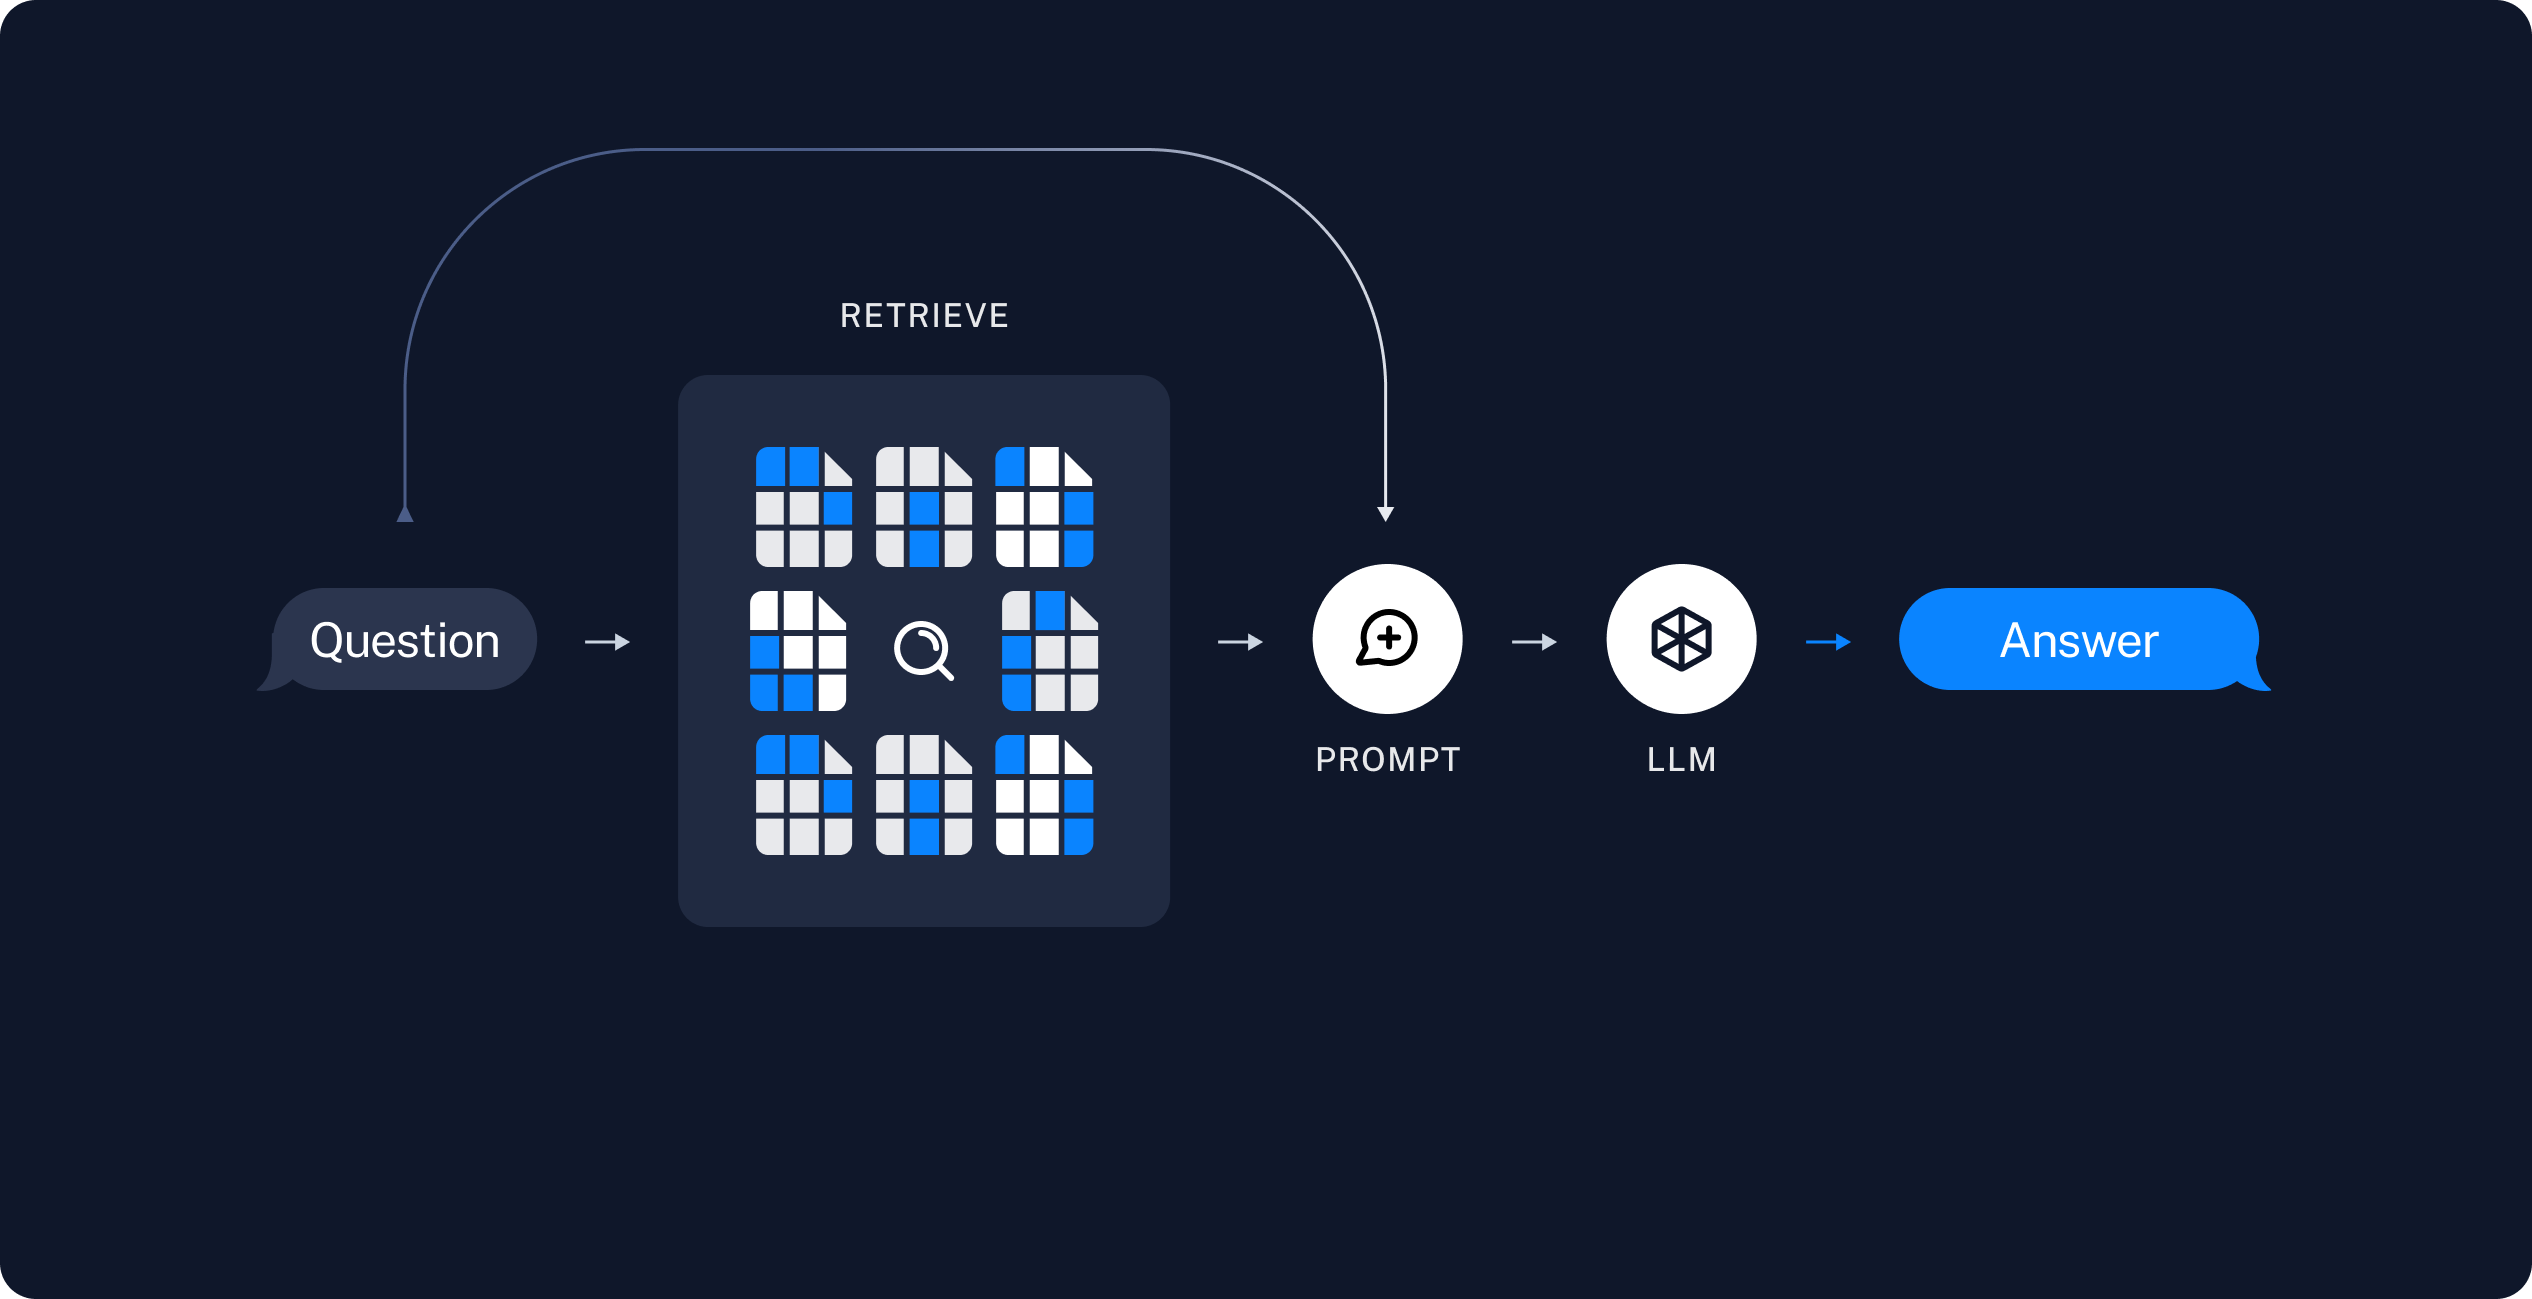

Source: [LangChain - Build a Retrieval Augmented Generation (RAG) App](https://python.langchain.com/docs/tutorials/rag/)

In [11]:
# Chain the vector store retriever, chat prompt template, and chat model together.
chain = (
  {'context': retriever,  'question': RunnablePassthrough()}
| chat_prompt_template
| chat_model
| StrOutputParser()
| RunnableLambda(extract_answer)
)

### Testing the Completed Chat Bot

With the chain, a query (or prompt) retrieves related documents from the vector store, fills in the blanks in the chat prompt template with the retrieved documents and the query, and asks the language model for an answer.

In [14]:
chain.invoke('What did Carter try to say in Chinese?')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'In the text, Carter tries to say the following Chinese phrase: \n\n1. "Shan-shui cao guo-jiu, pao gai niu tao zi" \n2. "Deng wa lu yun cai-shen wu" \n3. "Deng wa lu yun, shen wu wattu masu wang lui"'

Hint: everything Carter tries to say is nonsense.